# Agent Memory: Building Memory-Enabled Agents with LangGraph

In this notebook, we'll explore **agent memory systems** - the ability for AI agents to remember information across interactions. We'll implement all five memory types from the **CoALA (Cognitive Architectures for Language Agents)** framework while building on our Personal Wellness Assistant use case.

**Learning Objectives:**
- Understand the 5 memory types from the CoALA framework
- Implement short-term memory with checkpointers and thread_id
- Build long-term memory with InMemoryStore and namespaces
- Use semantic memory for meaning-based retrieval
- Apply episodic memory for few-shot learning from past experiences
- Create procedural memory for self-improving agents
- Combine all memory types into a unified wellness agent

## Table of Contents:

- **Breakout Room #1:** Memory Foundations
  - Task 1: Dependencies
  - Task 2: Understanding Agent Memory (CoALA Framework)
  - Task 3: Short-Term Memory (MemorySaver, thread_id)
  - Task 4: Long-Term Memory (InMemoryStore, namespaces)
  - Task 5: Message Trimming & Context Management
  - Question #1 & Question #2
  - 🏗️ Activity #1: Store & Retrieve User Wellness Profile

- **Breakout Room #2:** Advanced Memory & Integration
  - Task 6: Semantic Memory (Embeddings + Search)
  - Task 7: Building Semantic Wellness Knowledge Base
  - Task 8: Episodic Memory (Few-Shot Learning)
  - Task 9: Procedural Memory (Self-Improving Agent)
  - Task 10: Unified Wellness Memory Agent
  - Question #3 & Question #4
  - 🏗️ Activity #2: Wellness Memory Dashboard

---
# 🤝 Breakout Room #1
## Memory Foundations

## Task 1: Dependencies

Before we begin, make sure you have:

1. **API Keys** for:
   - OpenAI (for GPT-4o-mini and embeddings)
   - LangSmith (optional, for tracing)

2. **Dependencies installed** via `uv sync`

In [1]:
# Core imports
import os
import getpass
from uuid import uuid4
from typing import Annotated, TypedDict

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

In [2]:
# Set API Keys
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

In [3]:
# Optional: LangSmith for tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - Agent Memory - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key (press Enter to skip): ") or ""

if not os.environ["LANGCHAIN_API_KEY"]:
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    print("LangSmith tracing disabled")
else:
    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

LangSmith tracing enabled. Project: AIE9 - Agent Memory - 7896a53a


In [4]:
# Initialize LLM
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Test the connection
response = llm.invoke("Say 'Memory systems ready!' in exactly those words.")
print(response.content)

Memory systems ready!


## Task 2: Understanding Agent Memory (CoALA Framework)

The **CoALA (Cognitive Architectures for Language Agents)** framework identifies 5 types of memory that agents can use:

| Memory Type | Human Analogy | AI Implementation | Wellness Example |
|-------------|---------------|-------------------|------------------|
| **Short-term** | What someone just said | Conversation history within a thread | Current consultation conversation |
| **Long-term** | Remembering a friend's birthday | User preferences stored across sessions | User's goals, allergies, conditions |
| **Semantic** | Knowing Paris is in France | Facts retrieved by meaning | Wellness knowledge retrieval |
| **Episodic** | Remembering your first day at work | Learning from past experiences | Past successful advice patterns |
| **Procedural** | Knowing how to ride a bike | Self-improving instructions | Learned communication preferences |

### Memory Architecture Overview

```
┌─────────────────────────────────────────────────────────────────┐
│                    LangGraph Wellness Agent                     │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│  ┌──────────────┐  ┌──────────────┐  ┌──────────────┐           │
│  │  Short-term  │  │  Long-term   │  │   Semantic   │           │
│  │    Memory    │  │    Memory    │  │    Memory    │           │
│  │              │  │              │  │              │           │
│  │ Checkpointer │  │    Store     │  │Store+Embed   │           │
│  │ + thread_id  │  │ + namespace  │  │  + search()  │           │
│  └──────────────┘  └──────────────┘  └──────────────┘           │
│                                                                 │
│  ┌──────────────┐  ┌──────────────┐                             │
│  │   Episodic   │  │  Procedural  │                             │
│  │    Memory    │  │    Memory    │                             │
│  │              │  │              │                             │
│  │  Few-shot    │  │Self-modifying│                             │
│  │  examples    │  │   prompts    │                             │
│  └──────────────┘  └──────────────┘                             │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘
```

### Key LangGraph Components

| Component | Memory Type | Scope |
|-----------|-------------|-------|
| `MemorySaver` (Checkpointer) | Short-term | Within a single thread |
| `InMemoryStore` | Long-term, Semantic, Episodic, Procedural | Across all threads |
| `thread_id` | Short-term | Identifies unique conversations |
| Namespaces | All store-based | Organizes memories by user/purpose |

**Documentation:**
- [CoALA Paper](https://arxiv.org/abs/2309.02427)
- [LangGraph Memory Concepts](https://langchain-ai.github.io/langgraph/concepts/memory/)

## Task 3: Short-Term Memory (MemorySaver, thread_id)

**Short-term memory** maintains context within a single conversation thread. Think of it like your working memory during a phone call - you remember what was said earlier, but once the call ends, those details fade.

In LangGraph, short-term memory is implemented through:
- **Checkpointer**: Saves the graph state at each step
- **thread_id**: Uniquely identifies each conversation

### How It Works

```
Thread 1: "Hi, I'm Alice"          Thread 2: "What's my name?"
     │                                   │
     ▼                                   ▼
┌──────────────┐                   ┌──────────────┐
│ Checkpointer │                   │ Checkpointer │
│  thread_1    │                   │  thread_2    │
│              │                   │              │
│ ["Hi Alice"] │                   │ [empty]      │
└──────────────┘                   └──────────────┘
     │                                   │
     ▼                                   ▼
"Hi Alice!"                        "I don't know your name"
```

In [5]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

# Define the state schema for our graph
# The `add_messages` annotation tells LangGraph how to update the messages list
class State(TypedDict):
    messages: Annotated[list, add_messages]


# Define our wellness chatbot node
def wellness_chatbot(state: State):
    """Process the conversation and generate a wellness-focused response."""
    system_prompt = SystemMessage(content="""You are a friendly Personal Wellness Assistant. 
Help users with exercise, nutrition, sleep, and stress management questions.
Be supportive and remember details the user shares about themselves.""")
    
    messages = [system_prompt] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


# Build the graph
builder = StateGraph(State)
builder.add_node("chatbot", wellness_chatbot)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# Compile with a checkpointer for short-term memory
checkpointer = MemorySaver()
wellness_graph = builder.compile(checkpointer=checkpointer)

print("Wellness chatbot compiled with short-term memory (checkpointing)")

Wellness chatbot compiled with short-term memory (checkpointing)


In [6]:
# Test short-term memory within a thread
config = {"configurable": {"thread_id": "wellness_thread_1"}}

# First message - introduce ourselves
response = wellness_graph.invoke(
    {"messages": [HumanMessage(content="Hi! My name is Sarah and I want to improve my sleep.")]},
    config
)
print("User: Hi! My name is Sarah and I want to improve my sleep.")
print(f"Assistant: {response['messages'][-1].content}")
print()

User: Hi! My name is Sarah and I want to improve my sleep.
Assistant: Hi Sarah! It's great to meet you, and I'm glad you're focusing on improving your sleep. Sleep is so important for overall wellness. Can you tell me a bit more about your current sleep habits? For example, how many hours do you usually get, and do you have any specific challenges with your sleep?



In [7]:
# Second message - test if it remembers (same thread)
response = wellness_graph.invoke(
    {"messages": [HumanMessage(content="What's my name and what am I trying to improve?")]},
    config  # Same config = same thread_id
)
print("User: What's my name and what am I trying to improve?")
print(f"Assistant: {response['messages'][-1].content}")

User: What's my name and what am I trying to improve?
Assistant: Your name is Sarah, and you're trying to improve your sleep. If you have any specific challenges or questions about your sleep habits, feel free to share! I'm here to help.


In [8]:
# New thread - it won't remember Sarah!
different_config = {"configurable": {"thread_id": "wellness_thread_2"}}

response = wellness_graph.invoke(
    {"messages": [HumanMessage(content="What's my name?")]},
    different_config  # Different thread_id = no memory of Sarah
)
print("User (NEW thread): What's my name?")
print(f"Assistant: {response['messages'][-1].content}")
print()
print("Notice: The agent doesn't know our name because this is a new thread!")

User (NEW thread): What's my name?
Assistant: I don't have your name yet! If you'd like to share it, I can remember it for our future conversations. How can I assist you today?

Notice: The agent doesn't know our name because this is a new thread!


In [9]:
# Inspect the state of thread 1
state = wellness_graph.get_state(config)
print(f"Thread 1 has {len(state.values['messages'])} messages:")
for msg in state.values['messages']:
    role = "User" if isinstance(msg, HumanMessage) else "Assistant"
    content = msg.content[:80] + "..." if len(msg.content) > 80 else msg.content
    print(f"  {role}: {content}")

Thread 1 has 4 messages:
  User: Hi! My name is Sarah and I want to improve my sleep.
  Assistant: Hi Sarah! It's great to meet you, and I'm glad you're focusing on improving your...
  User: What's my name and what am I trying to improve?
  Assistant: Your name is Sarah, and you're trying to improve your sleep. If you have any spe...


## Task 4: Long-Term Memory (InMemoryStore, namespaces)

**Long-term memory** stores information across different conversation threads. This is like remembering that your friend prefers tea over coffee - you remember it every time you meet them, regardless of what you're currently discussing.

In LangGraph, long-term memory uses:
- **Store**: A persistent key-value store
- **Namespaces**: Organize memories by user, application, or context

### Key Difference from Short-Term Memory

| Short-Term (Checkpointer) | Long-Term (Store) |
|---------------------------|-------------------|
| Scoped to a single thread | Shared across all threads |
| Automatic (messages) | Explicit (you decide what to store) |
| Conversation history | User preferences, facts, etc. |

In [ ]:
from langgraph.store.memory import InMemoryStore


# ============================================================================
# LangGraph Store Structure: store.put(namespace, key, value)
# 
# - namespace: tuple[str, ...] - Groups related items. Think of it as a composite 
#   partition key. Supports prefix search: search(("user",)) matches all user namespaces.
# - key: str - Unique identifier within the namespace. Together (namespace, key) 
#   forms the full primary key. Like Row ID within the partition
# - value: dict - The data payload. Must be JSON-serializable.
#
# Example: store.put(("user_sarah", "profile"), "goals", {"primary": "sleep"})
#          namespace=("user_sarah", "profile"), key="goals", value={"primary": "sleep"}
# ============================================================================


# Create a store for long-term memory
store = InMemoryStore()

# Namespaces organize memories - typically by user_id and category
user_id = "user_sarah"
profile_namespace = (user_id, "profile")
preferences_namespace = (user_id, "preferences")

# Store Sarah's wellness profile
store.put(profile_namespace, "name", {"value": "Sarah"})
store.put(profile_namespace, "goals", {"primary": "improve sleep", "secondary": "reduce stress"})
store.put(profile_namespace, "conditions", {"allergies": ["peanuts"], "injuries": ["bad knee"]})

# Store Sarah's preferences
store.put(preferences_namespace, "communication", {"style": "friendly", "detail_level": "moderate"})
store.put(preferences_namespace, "schedule", {"preferred_workout_time": "morning", "available_days": ["Mon", "Wed", "Fri"]})

print("Stored Sarah's profile and preferences in long-term memory")

Stored Sarah's profile and preferences in long-term memory


None


In [11]:
# Retrieve specific memories
name = store.get(profile_namespace, "name")
print(f"Name: {name.value}")

goals = store.get(profile_namespace, "goals")
print(f"Goals: {goals.value}")

# List all memories in a namespace
print("\nAll profile items:")
for item in store.search(profile_namespace):
    print(f"  {item.key}: {item.value}")

Name: {'value': 'Sarah'}
Goals: {'primary': 'improve sleep', 'secondary': 'reduce stress'}

All profile items:
  name: {'value': 'Sarah'}
  goals: {'primary': 'improve sleep', 'secondary': 'reduce stress'}
  conditions: {'allergies': ['peanuts'], 'injuries': ['bad knee']}


In [13]:
from langgraph.store.base import BaseStore
from langchain_core.runnables import RunnableConfig

# Define state with user_id for personalization
class PersonalizedState(TypedDict):
    messages: Annotated[list, add_messages]
    user_id: str


# LangGraph Dependency Injection:
# - state: REQUIRED. Always passed automatically by the graph.
# - config: OPTIONAL. Add to signature to access runtime config passed via graph.invoke(..., config={...})
# - store: OPTIONAL. The "*" makes it keyword-only. Add to signature to access the store passed via graph.compile(store=...)
# Only include config/store if your node needs them. LangGraph inspects the signature and injects what you ask for.
def personalized_wellness_chatbot(state: PersonalizedState, config: RunnableConfig, *, store: BaseStore):
    """A wellness chatbot that uses long-term memory for personalization."""
    user_id = state["user_id"]
    profile_namespace = (user_id, "profile")
    preferences_namespace = (user_id, "preferences")
    
    # Retrieve user profile from long-term memory
    profile_items = list(store.search(profile_namespace))
    pref_items = list(store.search(preferences_namespace))
    
    # Build context from profile
    profile_text = "\n".join([f"- {p.key}: {p.value}" for p in profile_items])
    pref_text = "\n".join([f"- {p.key}: {p.value}" for p in pref_items])
    
    system_msg = f"""You are a Personal Wellness Assistant. You know the following about this user:

PROFILE:
{profile_text if profile_text else 'No profile stored.'}

PREFERENCES:
{pref_text if pref_text else 'No preferences stored.'}

Use this information to personalize your responses. Be supportive and helpful."""
    
    messages = [SystemMessage(content=system_msg)] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


# Build the personalized graph
builder2 = StateGraph(PersonalizedState)
builder2.add_node("chatbot", personalized_wellness_chatbot)
builder2.add_edge(START, "chatbot")
builder2.add_edge("chatbot", END)

# Compile with BOTH checkpointer (short-term) AND store (long-term)
personalized_graph = builder2.compile(
    checkpointer=MemorySaver(),
    store=store
)

print("Personalized graph compiled with both short-term and long-term memory")

Personalized graph compiled with both short-term and long-term memory


In [14]:
# Test the personalized chatbot - it knows Sarah's profile!
config = {"configurable": {"thread_id": "personalized_thread_1"}}

response = personalized_graph.invoke(
    {
        "messages": [HumanMessage(content="What exercises would you recommend for me?")],
        "user_id": "user_sarah"
    },
    config
)

print("User: What exercises would you recommend for me?")
print(f"Assistant: {response['messages'][-1].content}")
print()
print("Notice: The agent knows about Sarah's bad knee without her mentioning it!")

User: What exercises would you recommend for me?
Assistant: Hi Sarah! It's great that you're looking to improve your wellness. Given your goal to reduce stress and your bad knee, I recommend focusing on low-impact exercises that can help you relax while being gentle on your joints. Here are a few options you might enjoy:

1. **Walking**: A simple and effective way to get moving. Try to find a scenic route to make it more enjoyable!

2. **Swimming or Water Aerobics**: These are fantastic for a full-body workout without putting stress on your knee.

3. **Yoga**: This can help with both stress reduction and flexibility. Look for classes that focus on gentle or restorative yoga.

4. **Pilates**: Similar to yoga, Pilates can strengthen your core and improve flexibility while being mindful of your knee.

5. **Cycling**: If you have access to a stationary bike or can ride a bike on flat terrain, this is a great way to get your heart rate up without straining your knee.

Since you prefer to wo

In [15]:
# Even in a NEW thread, it still knows Sarah's profile
# because long-term memory is cross-thread!

new_config = {"configurable": {"thread_id": "personalized_thread_2"}}

response = personalized_graph.invoke(
    {
        "messages": [HumanMessage(content="Can you suggest a snack for me?")],
        "user_id": "user_sarah"
    },
    new_config
)

print("User (NEW thread): Can you suggest a snack for me?")
print(f"Assistant: {response['messages'][-1].content}")
print()
print("Notice: Even in a new thread, the agent knows Sarah has a peanut allergy!")

User (NEW thread): Can you suggest a snack for me?
Assistant: Absolutely, Sarah! Since you have a peanut allergy, let’s find something safe and satisfying. How about some apple slices with almond butter? It’s a great combination of fiber and healthy fats, which can help keep you full and satisfied. Just make sure to choose almond butter that’s made in a peanut-free facility to avoid any cross-contamination. 

If you’re looking for something lighter, you could also try some Greek yogurt with a sprinkle of cinnamon or a handful of berries. Both options are delicious and can be a nice treat! Let me know if you’d like more suggestions!

Notice: Even in a new thread, the agent knows Sarah has a peanut allergy!


## Task 5: Message Trimming & Context Management

Long conversations can exceed the LLM's context window. LangGraph provides utilities to manage message history:

- **`trim_messages`**: Keeps only recent messages up to a token limit
- **Summarization**: Compress older messages into summaries

### Why Trim Even with 128K Context?

Even with large context windows:
1. **Cost**: More tokens = higher API costs
2. **Latency**: Larger contexts take longer to process
3. **Quality**: Models can struggle with "lost in the middle" - important info buried in long contexts
4. **Relevance**: Old messages may not be relevant to current query

In [19]:
from langchain_core.messages import trim_messages

# Create a trimmer that keeps only recent messages
trimmer = trim_messages(
    max_tokens=100,  # Keep messages up to this token count
    strategy="last",  # Keep the most recent messages
    token_counter=llm,  # Use the LLM to count tokens
    include_system=True,  # Always keep system messages
    allow_partial=False,  # Don't cut messages in half
)

# Example: Create a long conversation
long_conversation = [
    SystemMessage(content="You are a wellness assistant."),
    HumanMessage(content="I want to improve my health."),
    AIMessage(content="Great goal! Let's start with exercise. What's your current activity level?"),
    HumanMessage(content="I walk about 30 minutes a day."),
    AIMessage(content="That's a good foundation. For cardiovascular health, aim for 150 minutes of moderate activity per week."),
    HumanMessage(content="What about nutrition?"),
    AIMessage(content="Focus on whole foods: vegetables, lean proteins, whole grains. Limit processed foods and added sugars."),
    HumanMessage(content="And sleep?"),
    AIMessage(content="Aim for 7-9 hours. Maintain a consistent sleep schedule and create a relaxing bedtime routine."),
    HumanMessage(content="What's the most important change I should make first?"),
]

# Trim to fit context window
trimmed = trimmer.invoke(long_conversation)
print(f"Original: {len(long_conversation)} messages")
print(f"Trimmed: {len(trimmed)} messages")
print("\nTrimmed conversation:")
for msg in trimmed:
    role = type(msg).__name__.replace("Message", "")
    content = msg.content[:60] + "..." if len(msg.content) > 60 else msg.content
    print(f"  {role}: {content}")

Original: 10 messages
Trimmed: 6 messages

Trimmed conversation:
  System: You are a wellness assistant.
  Human: What about nutrition?
  AI: Focus on whole foods: vegetables, lean proteins, whole grain...
  Human: And sleep?
  AI: Aim for 7-9 hours. Maintain a consistent sleep schedule and ...
  Human: What's the most important change I should make first?


In [20]:
# Summarization approach for longer conversations

def summarize_conversation(messages: list, max_messages: int = 6) -> list:
    """Summarize older messages to manage context length."""
    if len(messages) <= max_messages:
        return messages
    
    # Keep the system message and last few messages
    system_msg = messages[0] if isinstance(messages[0], SystemMessage) else None
    content_messages = messages[1:] if system_msg else messages
    
    if len(content_messages) <= max_messages:
        return messages
    
    old_messages = content_messages[:-max_messages+1]
    recent_messages = content_messages[-max_messages+1:]
    
    # Summarize old messages
    summary_prompt = f"""Summarize this conversation in 2-3 sentences, 
capturing key wellness topics discussed and any important user information:

{chr(10).join([f'{type(m).__name__}: {m.content[:200]}' for m in old_messages])}"""
    
    summary = llm.invoke(summary_prompt)
    
    # Return: system + summary + recent messages
    result = []
    if system_msg:
        result.append(system_msg)
    result.append(SystemMessage(content=f"[Previous conversation summary: {summary.content}]"))
    result.extend(recent_messages)
    
    return result


# Test summarization
summarized = summarize_conversation(long_conversation, max_messages=4)
print(f"Summarized: {len(summarized)} messages")
print("\nSummarized conversation:")
for msg in summarized:
    role = type(msg).__name__.replace("Message", "")
    content = msg.content[:80] + "..." if len(msg.content) > 80 else msg.content
    print(f"  {role}: {content}")

Summarized: 5 messages

Summarized conversation:
  System: You are a wellness assistant.
  System: [Previous conversation summary: The conversation centers around the user's desir...
  Human: And sleep?
  AI: Aim for 7-9 hours. Maintain a consistent sleep schedule and create a relaxing be...
  Human: What's the most important change I should make first?


---
## ❓ Question #1:

What are the trade-offs between **short-term memory** (checkpointer) vs **long-term memory** (store)? When should wellness data move from short-term to long-term?

Consider:
- What information should persist across sessions?
- What are the privacy implications of each?
- How would you decide what to promote from short-term to long-term?

##### Answer:
*Your answer here*

Pros of Short-term memory:
- Good for storing private/sensitive information that should only exists within current thread, and such information will be removed when the threads ends. Less liability in terms of privacy.
- Context is maintained across converstations in the same thread

Cons:
- Information/context will be lost when starting a new thread/conversation



Pros of Long-term memory:
- Memory can be accessed and updated across converstations/threads to provide more personalized and relevant answers to user in a mor eproactive way (e.g., system proactively recites user's preference/information to help user requests). 
- Good for storing user profile information such as height/weight in the case of the wellness system

Cons of Long-term memory:
- Require extra storage space to keep the information stored in long-term memory
- May not be best suited for private information, could potentially be subject to more regulations and need to design data retention policies or allow users to edit/remove memory.


When to promote information from short-term to long-term:
- Upon explict user request to always remember certain infomation
- When certain information is repeatedly mentioned or discussed by the user (e.g., I have allergy to XYZ) across threads
- Critical information that may lead to dangerous responses if not remebered in long-term memory (e.g., if user has allergy to nuts, system should remember that fact and do not recommend foold that has nuts).





## ❓ Question #2:

Why use message trimming with a 128K context window when HealthWellnessGuide.txt is only ~16KB? What should **always** be preserved when trimming a wellness consultation?

Consider:
- The "lost in the middle" phenomenon
- Cost and latency implications
- What user information is critical for safety (allergies, conditions, etc.)

##### Answer:
*Your answer here*

Reason to trim even if context window is large: 
- Improve LLM's attention to important task by avoding the "lost in the middle" phenomenon, since LLMs tend to pay more attention to the beginning and end of context.
- Very old messages could be less relevant to the most recent task, so trimming those could improve avoid context bloating and let agent attends to the most recent/relevant tasks. 
- Save cost due to serving less tokens
- Improve latency of the system since shorter context takes less time to process

Info to always preserve when trimming the wellness agent: 
- Keep the most recent converstations/tasks which should be more relevant to current task
- System messages which are the core instructions for the agent


---
## 🏗️ Activity #1: Store & Retrieve User Wellness Profile

Build a complete wellness profile system that:
1. Defines a wellness profile schema (name, goals, conditions, preferences)
2. Creates functions to store and retrieve profile data
3. Builds a personalized wellness agent that uses the profile
4. Tests that different users get different advice

### Requirements:
- Define at least 5 profile attributes
- Support multiple users with different profiles
- Agent should reference profile data in responses

In [26]:
### YOUR CODE HERE ###

# Step 1: Define a wellness profile schema
# Example attributes: name, age, goals, conditions, allergies, fitness_level, preferred_activities

# ============================================================================
# Profile Schema
# Namespace: (user_id, "profile")
# Keys: name, age, goals, conditions, fitness_level, preferred_activities
# ============================================================================

# Create a store for long-term memory
store = InMemoryStore()

# Step 2: Create helper functions to store and retrieve profiles
def store_wellness_profile(store, user_id: str, profile: dict):
    """Store a user's wellness profile."""
    user_profile_namespace = (user_id, "profile")
    for key, value in profile.items():
        if not isinstance(value, dict):
            value = {"value": value}
        store.put(user_profile_namespace, key, value)

def get_wellness_profile(store, user_id: str) -> dict:
    """Retrieve a user's wellness profile."""
    user_profile_namespace = (user_id, "profile")
    profile_items = list(store.search(user_profile_namespace))
    return {item.key: item.value for item in profile_items}


# Step 3: Create two different user profiles
alice_profile = {
    "name": {"value": "Alice"},
    "age": {"value": 20},
    "goals": {"primary": "lose weight", "secondary": "reduce stress"},
    "conditions": {"allergies": ["dairy", "gluten"], "injuries": []},
    "fitness_level": {"value": "beginner"},
    "preferred_activities": {"activities": ["yoga", "walking", "swimming"]}
}

bob_profile = {
    "name": {"value": "Bob"},
    "age": {"value": 52},
    "goals": {"primary": "build strength", "secondary": "improve flexibility"},
    "conditions": {"allergies": [], "injuries": ["lower back pain", "knee surgery"]},
    "fitness_level": {"value": "intermediate"},
    "preferred_activities": {"activities": ["weight training", "cycling"]}
}

store_wellness_profile(store, "alice_id", alice_profile)
store_wellness_profile(store, "bob_id", bob_profile)

# # Retrieve specific memories
# alice_profile = get_wellness_profile(store, "alice_id")

# # List all memories in a namespace
# print("\nAll profile items for Alice:")
# for key, value in alice_profile.items():
#     print(f"  {key}: {value}")

# bob_profile = get_wellness_profile(store, "bob_id")
# print("\nAll profile items for Bob:")
# for key, value in bob_profile.items():
#     print(f"  {key}: {value}")

# Step 4: Build a personalized agent that uses profiles
from langgraph.store.base import BaseStore
from langchain_core.runnables import RunnableConfig

# Define state with user_id for personalization
class PersonalizedState(TypedDict):
    messages: Annotated[list, add_messages]
    user_id: str

def personalized_wellness_chatbot(state: PersonalizedState, config: RunnableConfig, *, store: BaseStore):
    """A wellness chatbot that uses long-term memory for personalization."""
    user_id = state["user_id"]
    profile_namespace = (user_id, "profile")
    
    # Retrieve user profile from long-term memory
    profile_items = list(store.search(profile_namespace))
    
    # Build context from profile
    profile_text = "\n".join([f"- {p.key}: {p.value}" for p in profile_items])
    
    system_msg = f"""You are a Personal Wellness Assistant. You know the following about this user:

PROFILE:
{profile_text if profile_text else 'No profile stored.'}


Use this information to personalize your responses. Be supportive and helpful."""
    
    messages = [SystemMessage(content=system_msg)] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


# Build the personalized graph
personalized_workflow = StateGraph(PersonalizedState)
personalized_workflow.add_node("chatbot", personalized_wellness_chatbot)
personalized_workflow.add_edge(START, "chatbot")
personalized_workflow.add_edge("chatbot", END)

# Compile with BOTH checkpointer (short-term) AND store (long-term)
personalized_graph = personalized_workflow.compile(
    checkpointer=MemorySaver(),
    store=store
)

print("Personalized graph compiled with both short-term and long-term memory")

# Step 5: Test with different users - they should get different advice


Personalized graph compiled with both short-term and long-term memory


In [28]:
## Test 1:  Alice

# Test the personalized chatbot - it knows Alice's profile!
config = {"configurable": {"thread_id": "alice_thread_1"}}

response = personalized_graph.invoke(
    {
        "messages": [HumanMessage(content="What exercises would you recommend for me?")],
        "user_id": "alice_id"
    },
    config
)

print("User: What exercises would you recommend for me?")
print(f"Assistant: {response['messages'][-1].content}")
print()
print("Notice: The agent knows about Alice's interest in yoga and walking and is beginer level fitness")


User: What exercises would you recommend for me?
Assistant: Hi Alice! It's wonderful that you're looking to incorporate exercises into your routine. Given your beginner fitness level and your goals of losing weight and reducing stress, here are some tailored exercise recommendations:

1. **Walking**: Start with brisk walking for 20-30 minutes a day. It's a simple way to get moving, and you can enjoy the outdoors or listen to music or podcasts while you walk.

2. **Yoga**: Incorporate beginner-friendly yoga sessions into your week. Look for classes that focus on relaxation and stress relief, such as Hatha or Yin yoga. These can help improve flexibility and promote mindfulness.

3. **Swimming**: If you have access to a pool, swimming is a fantastic low-impact exercise. Aim for 20-30 minutes of swimming a few times a week. It’s great for cardiovascular fitness and can be very refreshing!

4. **Bodyweight Exercises**: As you feel more comfortable, you can add simple bodyweight exercises li

In [30]:
## Test 2:  Alice

# Test the short-term memory
config = {"configurable": {"thread_id": "alice_thread_1"}}

response = personalized_graph.invoke(
    {
        "messages": [HumanMessage(content="Can you tell more about the first exercise recommended?")],
        "user_id": "alice_id"
    },
    config
)

print("User: Can you tell more about the first exercise recommended?\n")
print(f"Assistant: {response['messages'][-1].content}")
print()
print("Notice: The agent knows about walking is the first exercise recommended")


User: Can you tell more about the first exercise recommended?

Assistant: Of course, Alice! Let’s dive deeper into walking as an exercise:

### Walking: An Overview

Walking is one of the simplest and most accessible forms of exercise. It requires no special equipment, can be done almost anywhere, and is suitable for all fitness levels, especially beginners like you.

### Benefits of Walking

1. **Weight Management**: Walking helps burn calories, which can contribute to weight loss when combined with a balanced diet. The number of calories burned depends on your weight, walking speed, and duration.

2. **Improved Mood**: Walking releases endorphins, which can help reduce stress and anxiety. It’s a great way to clear your mind and boost your mood.

3. **Enhanced Cardiovascular Health**: Regular walking strengthens your heart, improves circulation, and can lower blood pressure, reducing the risk of heart disease.

4. **Increased Energy Levels**: Walking can help improve your overall ener

In [31]:
# Test 3: Bob - Exercise (should avoid high-impact due to back/knee injuries)

config_bob = {"configurable": {"thread_id": "bob_thread_1"}}

response = personalized_graph.invoke(
    {"messages": [HumanMessage(content="What exercises would you recommend for me?")], "user_id": "bob_id"},
    config_bob
)


print("User: What exercises would you recommend for me?\n")
print(f"Assistant: {response['messages'][-1].content}\n")
print()
print("Notice: The agent knows about Bob's back/knee injuries and should avoid high-impact exercises")

User: What exercises would you recommend for me?

Assistant: Hi Bob! It's great to see you're focused on building strength and improving flexibility. Given your intermediate fitness level and your preferred activities, here are some exercise recommendations that can help you achieve your goals while being mindful of your lower back pain and knee surgery:

### Strength-Building Exercises:
1. **Weight Training:**
   - **Deadlifts (with proper form):** Focus on lighter weights to avoid straining your back. Consider using a trap bar or kettlebell to reduce stress on your lower back.
   - **Squats:** Bodyweight squats or goblet squats can be great. Make sure to keep your form in check to protect your knees.
   - **Bench Press or Dumbbell Press:** These can help build upper body strength. Use a spotter if you're lifting heavier weights.
   - **Seated Rows:** This exercise is excellent for your back and can be done with a cable machine or resistance bands.

2. **Cycling:**
   - Incorporate cy

---
# 🤝 Breakout Room #2
## Advanced Memory & Integration

## Task 6: Semantic Memory (Embeddings + Search)

**Semantic memory** stores facts and retrieves them based on *meaning* rather than exact matches. This is like how you might remember "that restaurant with the great pasta" even if you can't remember its exact name.

In LangGraph, semantic memory uses:
- **Store with embeddings**: Converts text to vectors for similarity search
- **`store.search()`**: Finds relevant memories by semantic similarity

### How It Works

```
User asks: "What helps with headaches?"
         ↓
Query embedded → [0.2, 0.8, 0.1, ...]
         ↓
Compare with stored wellness facts:
  - "Hydration can relieve headaches" → 0.92 similarity ✓
  - "Exercise improves sleep" → 0.35 similarity
         ↓
Return: "Hydration can relieve headaches"
```

In [32]:
from langchain_openai import OpenAIEmbeddings

# Create embeddings model
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Create a store with semantic search enabled
semantic_store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1536,  # Dimension of text-embedding-3-small
    }
)

print("Semantic memory store created with embedding support")

Semantic memory store created with embedding support


In [33]:
# Store various wellness facts as semantic memories
namespace = ("wellness", "facts")

wellness_facts = [
    ("fact_1", {"text": "Drinking water can help relieve headaches caused by dehydration"}),
    ("fact_2", {"text": "Regular exercise improves sleep quality and helps you fall asleep faster"}),
    ("fact_3", {"text": "Deep breathing exercises can reduce stress and anxiety within minutes"}),
    ("fact_4", {"text": "Eating protein at breakfast helps maintain steady energy levels throughout the day"}),
    ("fact_5", {"text": "Blue light from screens can disrupt your circadian rhythm and sleep"}),
    ("fact_6", {"text": "Walking for 30 minutes daily can improve cardiovascular health"}),
    ("fact_7", {"text": "Magnesium-rich foods like nuts and leafy greens can help with muscle cramps"}),
    ("fact_8", {"text": "A consistent sleep schedule, even on weekends, improves overall sleep quality"}),
]

for key, value in wellness_facts:
    semantic_store.put(namespace, key, value)

print(f"Stored {len(wellness_facts)} wellness facts in semantic memory")

Stored 8 wellness facts in semantic memory


In [40]:
# Search semantically - notice we don't need exact matches!

queries = [
    "My head hurts, what should I do?",
    "How can I get better rest at night?",
    "I'm feeling stressed and anxious",
    "What should I eat in the morning?",
]

for query in queries:
    print(f"\nQuery: {query}")
    results = semantic_store.search(namespace, query=query, limit=2)
    for r in results:
        print(f"   {r.value['text']} (score: {r.score:.3f})")


Query: My head hurts, what should I do?
   Drinking water can help relieve headaches caused by dehydration (score: 0.327)
   Magnesium-rich foods like nuts and leafy greens can help with muscle cramps (score: 0.173)

Query: How can I get better rest at night?
   Regular exercise improves sleep quality and helps you fall asleep faster (score: 0.463)
   A consistent sleep schedule, even on weekends, improves overall sleep quality (score: 0.426)

Query: I'm feeling stressed and anxious
   Deep breathing exercises can reduce stress and anxiety within minutes (score: 0.415)
   Drinking water can help relieve headaches caused by dehydration (score: 0.224)

Query: What should I eat in the morning?
   Eating protein at breakfast helps maintain steady energy levels throughout the day (score: 0.467)
   Walking for 30 minutes daily can improve cardiovascular health (score: 0.249)


## Task 7: Building Semantic Wellness Knowledge Base

Let's load the HealthWellnessGuide.txt and create a semantic knowledge base that our agent can search.

This is similar to RAG from Session 4, but now using LangGraph's Store API instead of a separate vector database.

In [35]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load and chunk the wellness document
loader = TextLoader("data/HealthWellnessGuide.txt")
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)
chunks = text_splitter.split_documents(documents)

print(f"Loaded and split into {len(chunks)} chunks")
print(f"\nSample chunk:\n{chunks[0].page_content[:200]}...")

Loaded and split into 45 chunks

Sample chunk:
The Personal Wellness Guide
A Comprehensive Resource for Health and Well-being

PART 1: EXERCISE AND MOVEMENT

Chapter 1: Understanding Exercise Basics

Exercise is one of the most important things yo...


In [36]:
# Store chunks in semantic memory
knowledge_namespace = ("wellness", "knowledge")

for i, chunk in enumerate(chunks):
    semantic_store.put(
        knowledge_namespace,
        f"chunk_{i}",
        {"text": chunk.page_content, "source": "HealthWellnessGuide.txt"}
    )

print(f"Stored {len(chunks)} chunks in semantic knowledge base")

Stored 45 chunks in semantic knowledge base


In [37]:
# Build a semantic search wellness chatbot

class SemanticState(TypedDict):
    messages: Annotated[list, add_messages]
    user_id: str


def semantic_wellness_chatbot(state: SemanticState, config: RunnableConfig, *, store: BaseStore):
    """A wellness chatbot that retrieves relevant facts using semantic search."""
    user_message = state["messages"][-1].content
    
    # Search for relevant knowledge
    knowledge_results = store.search(
        ("wellness", "knowledge"),
        query=user_message,
        limit=3
    )
    
    # Build context from retrieved knowledge
    if knowledge_results:
        knowledge_text = "\n\n".join([f"- {r.value['text']}" for r in knowledge_results])
        system_msg = f"""You are a Personal Wellness Assistant with access to a wellness knowledge base.

Relevant information from your knowledge base:
{knowledge_text}

Use this information to answer the user's question. If the information doesn't directly answer their question, use your general knowledge but mention what you found."""
    else:
        system_msg = "You are a Personal Wellness Assistant. Answer wellness questions helpfully."
    
    messages = [SystemMessage(content=system_msg)] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


# Build and compile
builder3 = StateGraph(SemanticState)
builder3.add_node("chatbot", semantic_wellness_chatbot)
builder3.add_edge(START, "chatbot")
builder3.add_edge("chatbot", END)

semantic_graph = builder3.compile(
    checkpointer=MemorySaver(),
    store=semantic_store
)

print("Semantic wellness chatbot ready")

Semantic wellness chatbot ready


In [38]:
# Test semantic retrieval
config = {"configurable": {"thread_id": "semantic_thread_1"}}

questions = [
    "What exercises can help with lower back pain?",
    "How can I improve my sleep quality?",
    "What should I eat for better gut health?",
]

for q in questions:
    response = semantic_graph.invoke(
        {"messages": [HumanMessage(content=q)], "user_id": "test_user"},
        config
    )
    print(f"\nUser: {q}")
    print(f"Assistant: {response['messages'][-1].content[:500]}...")


User: What exercises can help with lower back pain?
Assistant: There are several effective exercises that can help alleviate lower back pain. Here are some recommended ones:

1. **Cat-Cow Stretch**: Start on your hands and knees. Alternate between arching your back up (like a cat) and letting it sag down (like a cow). Perform 10-15 repetitions.

2. **Bird Dog**: From a hands-and-knees position, extend one arm and the opposite leg while keeping your core engaged. Hold for 5 seconds, then switch sides. Aim for 10 repetitions per side.

3. **Partial Crunches**...

User: How can I improve my sleep quality?
Assistant: Improving your sleep quality can be achieved through several essential sleep hygiene practices and creating an optimal sleep environment. Here are some tips:

### Sleep Hygiene Practices:
1. **Maintain a Consistent Sleep Schedule**: Go to bed and wake up at the same time every day, even on weekends.
2. **Create a Relaxing Bedtime Routine**: Engage in calming activities before

## Task 8: Episodic Memory (Few-Shot Learning)

**Episodic memory** stores past experiences and uses them as examples for future tasks. In humans, this is like remembering the first time you successfully gave someone good advice and using that experience to guide future interactions.

For AI agents, episodic memory is often implemented as **few-shot examples** - showing the model examples of correct behavior so it can learn patterns.

### The CoALA Framework Perspective

> "Facts can be written to semantic memory, whereas **experiences** can be written to episodic memory."

Key insight: Sometimes it's easier to **show** than **tell**. LLMs learn well from examples!

In [41]:
# Create episodic memory with past successful interactions
episodic_namespace = ("agent", "episodes")

successful_episodes = [
    {
        "situation": "User asked about starting exercise with joint pain",
        "input": "I want to start exercising but my knees hurt. What should I do?",
        "output": """For knee-friendly exercise, I'd recommend starting with low-impact activities:

1. **Swimming or water aerobics** - Water supports your joints while providing great cardio
2. **Cycling** - Either stationary or regular bikes are gentle on knees
3. **Elliptical machine** - Provides cardio without impact

Start slowly with 15-20 minutes and gradually increase. If you experience pain, stop and consult a healthcare provider. Would you like specific exercises for any of these?""",
        "feedback": "User appreciated the specific alternatives and safety advice"
    },
    {
        "situation": "User struggling with sleep and stress",
        "input": "I can't fall asleep because I'm always thinking about work. Help!",
        "output": """Racing thoughts at bedtime is common, especially with work stress. Here's a proven approach:

**Before bed:**
- Write down tomorrow's to-do list (gets thoughts out of your head)
- Set a "worry time" earlier in the evening - not at bedtime

**At bedtime:**
- Try the 4-7-8 breathing technique: Inhale 4 counts, hold 7, exhale 8
- Use the "cognitive shuffle" - think of random, unrelated objects (apple, guitar, mountain...)

Which of these would you like to try first?""",
        "feedback": "User found the structured approach and specific techniques helpful"
    },
    {
        "situation": "User asking about healthy eating on a budget",
        "input": "How can I eat healthy when I don't have much money?",
        "output": """Eating healthy on a budget is absolutely possible! Here are practical strategies:

**Budget-friendly nutritious foods:**
- Eggs, beans, lentils (cheap protein)
- Frozen vegetables (same nutrition as fresh, longer lasting)
- Oats, rice, whole grain bread
- Canned fish (tuna, salmon)

**Money-saving tips:**
- Buy in bulk when possible
- Plan meals around sales
- Cook in batches and freeze portions

What's your typical weekly food budget? I can help you create a specific meal plan.""",
        "feedback": "User valued the practical, actionable advice without judgment"
    },
]

for i, episode in enumerate(successful_episodes):
    semantic_store.put(
        episodic_namespace,
        f"episode_{i}",
        {
            "text": episode["situation"],  # Used for semantic search
            **episode
        }
    )

print(f"Stored {len(successful_episodes)} episodic memories (past successful interactions)")

Stored 3 episodic memories (past successful interactions)


In [42]:
class EpisodicState(TypedDict):
    messages: Annotated[list, add_messages]


def episodic_wellness_chatbot(state: EpisodicState, config: RunnableConfig, *, store: BaseStore):
    """A chatbot that learns from past successful interactions."""
    user_question = state["messages"][-1].content
    
    # Search for similar past experiences
    similar_episodes = store.search(
        ("agent", "episodes"),
        query=user_question,
        limit=1
    )
    
    # Build few-shot examples from past episodes
    if similar_episodes:
        episode = similar_episodes[0].value
        few_shot_example = f"""Here's an example of a similar wellness question I handled well:

User asked: {episode['input']}

My response was:
{episode['output']}

The user feedback was: {episode['feedback']}

Use this as inspiration for the style, structure, and tone of your response, but tailor it to the current question."""
        
        system_msg = f"""You are a Personal Wellness Assistant. Learn from your past successes:

{few_shot_example}"""
    else:
        system_msg = "You are a Personal Wellness Assistant. Be helpful, specific, and supportive."
    
    messages = [SystemMessage(content=system_msg)] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


# Build the episodic memory graph
builder4 = StateGraph(EpisodicState)
builder4.add_node("chatbot", episodic_wellness_chatbot)
builder4.add_edge(START, "chatbot")
builder4.add_edge("chatbot", END)

episodic_graph = builder4.compile(
    checkpointer=MemorySaver(),
    store=semantic_store
)

print("Episodic memory chatbot ready")

Episodic memory chatbot ready


In [43]:
# Test episodic memory - similar question to stored episode
config = {"configurable": {"thread_id": "episodic_thread_1"}}

response = episodic_graph.invoke(
    {"messages": [HumanMessage(content="I want to exercise more but I have a bad hip. What can I do?")]},
    config
)

print("User: I want to exercise more but I have a bad hip. What can I do?")
print(f"\nAssistant: {response['messages'][-1].content}")
print("\nNotice: The response structure mirrors the successful knee pain episode!")

User: I want to exercise more but I have a bad hip. What can I do?

Assistant: It's great that you want to exercise more! For a bad hip, focusing on low-impact activities can help you stay active while minimizing discomfort. Here are some options to consider:

1. **Swimming or water aerobics** - The buoyancy of water reduces stress on your hip joints while providing a full-body workout.
2. **Cycling** - Using a stationary bike or cycling outdoors can be gentle on your hips and still give you a good cardiovascular workout.
3. **Walking** - Opt for flat, even surfaces and start with short distances. Gradually increase your pace and distance as you feel comfortable.
4. **Yoga or Pilates** - These practices can improve flexibility and strength without putting too much strain on your hips. Look for classes that focus on gentle movements.
5. **Resistance training** - Using light weights or resistance bands can help strengthen the muscles around your hip, providing better support.

Start with

## Task 9: Procedural Memory (Self-Improving Agent)

**Procedural memory** stores the rules and instructions that guide behavior. In humans, this is like knowing *how* to give good advice - it's internalized knowledge about performing tasks.

For AI agents, procedural memory often means **self-modifying prompts**. The agent can:
1. Store its current instructions in the memory store
2. Reflect on feedback from interactions
3. Update its own instructions to improve

### The Reflection Pattern

```
User feedback: "Your advice is too long and complicated"
         ↓
Agent reflects on current instructions
         ↓
Agent updates instructions: "Keep advice concise and actionable"
         ↓
Future responses use updated instructions
```

In [44]:
# Initialize procedural memory with base instructions
procedural_namespace = ("agent", "instructions")

initial_instructions = """You are a Personal Wellness Assistant.

Guidelines:
- Be supportive and non-judgmental
- Provide evidence-based wellness information
- Ask clarifying questions when needed
- Encourage healthy habits without being preachy"""

semantic_store.put(
    procedural_namespace,
    "wellness_assistant",
    {"instructions": initial_instructions, "version": 1}
)

print("Initialized procedural memory with base instructions")
print(f"\nCurrent Instructions (v1):\n{initial_instructions}")

Initialized procedural memory with base instructions

Current Instructions (v1):
You are a Personal Wellness Assistant.

Guidelines:
- Be supportive and non-judgmental
- Provide evidence-based wellness information
- Ask clarifying questions when needed
- Encourage healthy habits without being preachy


In [45]:
class ProceduralState(TypedDict):
    messages: Annotated[list, add_messages]
    feedback: str  # Optional feedback from user


def get_instructions(store: BaseStore) -> tuple[str, int]:
    """Retrieve current instructions from procedural memory."""
    item = store.get(("agent", "instructions"), "wellness_assistant")
    if item is None:
        return "You are a helpful wellness assistant.", 0
    return item.value["instructions"], item.value["version"]


def procedural_assistant_node(state: ProceduralState, config: RunnableConfig, *, store: BaseStore):
    """Respond using current procedural instructions."""
    instructions, version = get_instructions(store)
    
    messages = [SystemMessage(content=instructions)] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


def reflection_node(state: ProceduralState, config: RunnableConfig, *, store: BaseStore):
    """Reflect on feedback and update instructions if needed."""
    feedback = state.get("feedback", "")
    
    if not feedback:
        return {}  # No feedback, no update needed
    
    # Get current instructions
    current_instructions, version = get_instructions(store)
    
    # Ask the LLM to reflect and improve instructions
    reflection_prompt = f"""You are improving a wellness assistant's instructions based on user feedback.

Current Instructions:
{current_instructions}

User Feedback:
{feedback}

Based on this feedback, provide improved instructions. Keep the same general format but incorporate the feedback.
Only output the new instructions, nothing else."""
    
    response = llm.invoke([HumanMessage(content=reflection_prompt)])
    new_instructions = response.content
    
    # Update procedural memory with new instructions
    store.put(
        ("agent", "instructions"),
        "wellness_assistant",
        {"instructions": new_instructions, "version": version + 1}
    )
    
    print(f"\nInstructions updated to version {version + 1}")
    return {}


def should_reflect(state: ProceduralState) -> str:
    """Decide whether to reflect on feedback."""
    if state.get("feedback"):
        return "reflect"
    return "end"


# Build the procedural memory graph
builder5 = StateGraph(ProceduralState)
builder5.add_node("assistant", procedural_assistant_node)
builder5.add_node("reflect", reflection_node)

builder5.add_edge(START, "assistant")
builder5.add_conditional_edges("assistant", should_reflect, {"reflect": "reflect", "end": END})
builder5.add_edge("reflect", END)

procedural_graph = builder5.compile(
    checkpointer=MemorySaver(),
    store=semantic_store
)

print("Procedural memory graph ready (with self-improvement capability)")

Procedural memory graph ready (with self-improvement capability)


In [46]:
# Test with initial instructions
config = {"configurable": {"thread_id": "procedural_thread_1"}}

response = procedural_graph.invoke(
    {
        "messages": [HumanMessage(content="How can I reduce stress?")],
        "feedback": ""  # No feedback yet
    },
    config
)

print("User: How can I reduce stress?")
print(f"\nAssistant (v1 instructions):\n{response['messages'][-1].content}")

User: How can I reduce stress?

Assistant (v1 instructions):
Reducing stress is a great goal, and there are several effective strategies you can try. Here are some evidence-based methods:

1. **Mindfulness and Meditation**: Practicing mindfulness or meditation can help you stay present and reduce anxiety. Even a few minutes a day can make a difference.

2. **Physical Activity**: Regular exercise is a powerful stress reliever. It can boost your mood and improve your overall well-being. What types of physical activities do you enjoy?

3. **Deep Breathing Exercises**: Simple deep breathing techniques can help calm your mind and body. Try inhaling deeply for a count of four, holding for four, and exhaling for four.

4. **Connect with Others**: Talking to friends or family can provide support and help you feel less isolated. Do you have someone you feel comfortable reaching out to?

5. **Time Management**: Sometimes, stress comes from feeling overwhelmed. Organizing your tasks and setting p

In [47]:
# Now provide feedback - the agent will update its own instructions!
response = procedural_graph.invoke(
    {
        "messages": [HumanMessage(content="How can I reduce stress?")],
        "feedback": "Your responses are too long. Please be more concise and give me 3 actionable tips maximum."
    },
    {"configurable": {"thread_id": "procedural_thread_2"}}
)


Instructions updated to version 2


In [48]:
# Check the updated instructions
new_instructions, version = get_instructions(semantic_store)
print(f"Updated Instructions (v{version}):\n")
print(new_instructions)

Updated Instructions (v2):

You are a Personal Wellness Assistant.

Guidelines:
- Be supportive and non-judgmental
- Provide concise, evidence-based wellness information
- Offer a maximum of 3 actionable tips
- Ask clarifying questions when needed
- Encourage healthy habits without being preachy


In [49]:
# Test with updated instructions - should be more concise now!
response = procedural_graph.invoke(
    {
        "messages": [HumanMessage(content="How can I sleep better?")],
        "feedback": ""  # No feedback this time
    },
    {"configurable": {"thread_id": "procedural_thread_3"}}
)

print(f"User: How can I sleep better?")
print(f"\nAssistant (v{version} instructions - after feedback):")
print(response['messages'][-1].content)
print("\nNotice: The response should now be more concise based on the feedback!")

User: How can I sleep better?

Assistant (v2 instructions - after feedback):
Improving your sleep can have a significant impact on your overall wellness. Here are three actionable tips to help you sleep better:

1. **Establish a Consistent Sleep Schedule**: Try to go to bed and wake up at the same time every day, even on weekends. This helps regulate your body's internal clock.

2. **Create a Relaxing Bedtime Routine**: Engage in calming activities before bed, such as reading, taking a warm bath, or practicing relaxation techniques like deep breathing or meditation. This signals to your body that it's time to wind down.

3. **Limit Screen Time Before Bed**: Reduce exposure to screens (phones, tablets, TVs) at least an hour before bedtime. The blue light emitted can interfere with your ability to fall asleep.

Are there specific challenges you're facing with your sleep that you'd like to discuss?

Notice: The response should now be more concise based on the feedback!


## Task 10: Unified Wellness Memory Agent

Now let's combine **all 5 memory types** into a unified wellness agent:

1. **Short-term**: Remembers current conversation (checkpointer)
2. **Long-term**: Stores user profile across sessions (store + namespace)
3. **Semantic**: Retrieves relevant wellness knowledge (store + embeddings)
4. **Episodic**: Uses past successful interactions as examples (store + search)
5. **Procedural**: Adapts behavior based on feedback (store + reflection)

### Memory Retrieval Flow

```
User Query: "What exercises can help my back pain?"
              │
              ▼
┌─────────────────────────────────────────────────┐
│  1. PROCEDURAL: Get current instructions         │
│  2. LONG-TERM: Load user profile (conditions)    │
│  3. SEMANTIC: Search wellness knowledge          │
│  4. EPISODIC: Find similar past interactions     │
│  5. SHORT-TERM: Include conversation history     │
└─────────────────────────────────────────────────┘
              │
              ▼
        Generate personalized, informed response
```

In [51]:
class UnifiedState(TypedDict):
    messages: Annotated[list, add_messages]
    user_id: str
    feedback: str


def unified_wellness_assistant(state: UnifiedState, config: RunnableConfig, *, store: BaseStore):
    """An assistant that uses all five memory types."""
    user_id = state["user_id"]
    user_message = state["messages"][-1].content
    
    # 1. PROCEDURAL: Get current instructions
    instructions_item = store.get(("agent", "instructions"), "wellness_assistant")
    base_instructions = instructions_item.value["instructions"] if instructions_item else "You are a helpful wellness assistant."
    
    # 2. LONG-TERM: Get user profile
    profile_items = list(store.search((user_id, "profile")))
    pref_items = list(store.search((user_id, "preferences")))
    profile_text = "\n".join([f"- {p.key}: {p.value}" for p in profile_items]) if profile_items else "No profile stored."
    
    # 3. SEMANTIC: Search for relevant knowledge
    relevant_knowledge = store.search(("wellness", "knowledge"), query=user_message, limit=2)
    knowledge_text = "\n".join([f"- {r.value['text'][:200]}..." for r in relevant_knowledge]) if relevant_knowledge else "No specific knowledge found."
    
    # 4. EPISODIC: Find similar past interactions
    similar_episodes = store.search(("agent", "episodes"), query=user_message, limit=1)
    if similar_episodes:
        ep = similar_episodes[0].value
        episode_text = f"Similar past interaction:\nUser: {ep.get('input', 'N/A')}\nResponse style: {ep.get('feedback', 'N/A')}"
    else:
        episode_text = "No similar past interactions found."
    
    # Build comprehensive system message
    system_message = f"""{base_instructions}

=== USER PROFILE ===
{profile_text}

=== RELEVANT WELLNESS KNOWLEDGE ===
{knowledge_text}

=== LEARNING FROM EXPERIENCE ===
{episode_text}

Use all of this context to provide the best possible personalized response."""
    
    # 5. SHORT-TERM: Full conversation history is automatically managed by the checkpointer
    # Use summarization for long conversations
    trimmed_messages = summarize_conversation(state["messages"], max_messages=6)
    
    messages = [SystemMessage(content=system_message)] + trimmed_messages
    response = llm.invoke(messages)
    return {"messages": [response]}


def unified_feedback_node(state: UnifiedState, config: RunnableConfig, *, store: BaseStore):
    """Update procedural memory based on feedback."""
    feedback = state.get("feedback", "")
    if not feedback:
        return {}
    
    item = store.get(("agent", "instructions"), "wellness_assistant")
    if item is None:
        return {}
    
    current = item.value
    reflection_prompt = f"""Update these instructions based on feedback:

Current: {current['instructions']}
Feedback: {feedback}

Output only the updated instructions."""
    
    response = llm.invoke([HumanMessage(content=reflection_prompt)])
    store.put(
        ("agent", "instructions"),
        "wellness_assistant",
        {"instructions": response.content, "version": current["version"] + 1}
    )
    print(f"Procedural memory updated to v{current['version'] + 1}")
    return {}


def unified_route(state: UnifiedState) -> str:
    return "feedback" if state.get("feedback") else "end"


# Build the unified graph
unified_builder = StateGraph(UnifiedState)
unified_builder.add_node("assistant", unified_wellness_assistant)
unified_builder.add_node("feedback", unified_feedback_node)

unified_builder.add_edge(START, "assistant")
unified_builder.add_conditional_edges("assistant", unified_route, {"feedback": "feedback", "end": END})
unified_builder.add_edge("feedback", END)

# Compile with both checkpointer (short-term) and store (all other memory types)
unified_graph = unified_builder.compile(
    checkpointer=MemorySaver(),
    store=semantic_store
)

print("Unified wellness assistant ready with all 5 memory types!")

Unified wellness assistant ready with all 5 memory types!


In [55]:
# Namespaces organize memories - typically by user_id and category
profile_namespace = ("user_sarah", "profile")
preferences_namespace = ("user_sarah", "preferences")

# Store Sarah's wellness profile
semantic_store.put(profile_namespace, "name", {"value": "Sarah"})
semantic_store.put(profile_namespace, "goals", {"primary": "improve sleep", "secondary": "reduce stress"})
semantic_store.put(profile_namespace, "conditions", {"allergies": ["peanuts"], "injuries": ["bad knee"]})

# Store Sarah's preferences
semantic_store.put(preferences_namespace, "communication", {"style": "friendly", "detail_level": "moderate"})
semantic_store.put(preferences_namespace, "schedule", {"preferred_workout_time": "morning", "available_days": ["Mon", "Wed", "Fri"]})


In [59]:
# Test the unified assistant
config = {"configurable": {"thread_id": "unified_thread_1"}}

# First interaction - should use semantic + long-term + episodic memory
response = unified_graph.invoke(
    {
        "messages": [HumanMessage(content="What exercises would you recommend for my back given my past experience and injuries?")],
        "user_id": "user_sarah",  # Sarah has a bad knee in her profile!
        "feedback": ""
    },
    config
)

print("User: What exercises would you recommend for my back?")
print(f"\nAssistant: {response['messages'][-1].content}")
print("\n" + "="*60)
print("Memory types used:")
print("  Long-term: Knows Sarah has a bad knee")
print("  Semantic: Retrieved back exercise info from knowledge base")
print("  Episodic: May use similar joint pain episode as reference")
print("  Procedural: Following current instructions")
print("  Short-term: Will remember this in follow-up questions")

User: What exercises would you recommend for my back?

Assistant: Given your bad knee and the need for gentle movements, here are three exercises that can help support your back while being mindful of your knee:

1. **Cat-Cow Stretch**: This gentle stretch helps improve flexibility in your spine. Start on your hands and knees. Inhale as you arch your back (Cow), and exhale as you round your back (Cat). Repeat for 10-15 repetitions.

2. **Seated Forward Bend**: Sit on the floor with your legs extended in front of you. Inhale and reach your arms overhead, then exhale as you hinge at your hips to reach toward your toes. This stretch can help relieve tension in your back without putting pressure on your knees.

3. **Child’s Pose**: Start on your hands and knees, then sit back on your heels while reaching your arms forward on the ground. This position gently stretches your back and can be very relaxing.

Always listen to your body and stop if you feel any pain. Would you like more details o

In [60]:
# Follow-up question (tests short-term memory)
response = unified_graph.invoke(
    {
        "messages": [HumanMessage(content="Can you show me how to do the first one?")],
        "user_id": "user_sarah",
        "feedback": ""
    },
    config  # Same thread
)

print("User: Can you show me how to do the first one?")
print(f"\nAssistant: {response['messages'][-1].content}")
print("\nNotice: The agent remembers the context from the previous message!")

User: Can you show me how to do the first one?

Assistant: Absolutely! Here’s how to do the Cat-Cow Stretch step-by-step:

1. **Start Position**: Begin on your hands and knees in a tabletop position. Your wrists should be directly under your shoulders, and your knees should be under your hips. Keep your back flat and your neck in a neutral position.

2. **Cat Pose**: 
   - Inhale deeply.
   - As you exhale, round your back towards the ceiling, tucking your chin to your chest and drawing your belly button towards your spine. This is the "Cat" position.

3. **Cow Pose**: 
   - Inhale again.
   - As you exhale, arch your back, allowing your belly to drop towards the floor. Lift your head and tailbone towards the ceiling. This is the "Cow" position.

4. **Repeat**: Continue to alternate between Cat and Cow for 10-15 repetitions, synchronizing your breath with your movements.

Remember to move slowly and gently, focusing on the stretch and how it feels in your back. Let me know if you have 

---
## ❓ Question #3:

How would you decide what constitutes a **"successful" wellness interaction** worth storing as an episode? What metadata should you store alongside the episode?

Consider:
- Explicit feedback (thumbs up) vs implicit signals
- User engagement (did they ask follow-up questions?)
- Objective outcomes vs subjective satisfaction
- Privacy implications of storing interaction data

##### Answer:
*Your answer here*

The following situations can be considered a succesful wellness interaction that worth storing an episode:

- User provides positive feedback and/or strong engagement for a previous interaction/response. This can be provided from user's prompt to previous response(e.g., they specify/acknowledge in their prompt that response is great); 
- In a web interface where user explictly provides a thumbs up to a previous response
- Implicit engagement signals like user asks follow-up/elaboration questions, user reports back to the thread on actually implementing the recommendations.


Metadata that can be stored in the episode:
- Timestamp the episode is added;
- User feedback signal: explict user request vs. implicit trigger
- Interaction type: topic/category of the guidance, e.g., sleep, stress, nutrition, etc.

Privacy considerations:
- Avoid storing sensitive information, e.g., PII data


## ❓ Question #4:

For a **production wellness assistant**, which memory types need persistent storage (PostgreSQL) vs in-memory? How would you handle memory across multiple agent instances (e.g., Exercise Agent, Nutrition Agent, Sleep Agent)?

Consider:
- Which memories are user-specific vs shared?
- Consistency requirements across agents
- Memory expiration and cleanup policies
- Namespace strategy for multi-agent systems

##### Answer:
Which memory types need persistent storage (PostgreSQL) vs in-memory?

- Short-term memory: can use in-memory store, since the history is only needed during the active session, which can be discarded/cleared when conversation ends. This is user-specific memory. 
- Long-term memory: use persistent storage for storing things like user profile/preference. This can be user-specific. In general the data would not expire unless user decides to remove that from memory.
- Semantic memory: use persistent storage for storing facts and knowledge base. This is general knowledge shared across users.
- Episodic memory: use persistent storage for storing and retrieving past successful interactions with the user. This can be user specific since different users may have different preferences for successful interactions. We could favor recent episodes vs. older episodes.
- Procedural memory: use persistent storage for storing base system instructions, which also needs to be retrieved and updated. The base instruction is shared across users. This memory can be version controlled. 


How to handle memory across multiple agent instances?

- I would use a shared persistent memory store for long term memory types, that all agents read from and write to. For example, this ensures when sleep agent learns something about the user, nutrition agent and exercise agent can access it as well. Some other considerations for each memory type are discussed earlier.



---
## 🏗️ Activity #2: Wellness Memory Dashboard

Build a wellness tracking system that:
1. Tracks wellness metrics over time (mood, energy, sleep quality)
2. Uses semantic memory to find relevant advice
3. Uses episodic memory to recall what worked before
4. Uses procedural memory to adapt advice style
5. Provides a synthesized "wellness summary"

### Requirements:
- Store at least 3 wellness metrics per user
- Track metrics over multiple "days" (simulated)
- Agent should reference historical data in responses
- Generate a personalized wellness summary

### Design Documentation

For detailed design documentation including architecture diagram, memory namespaces schema, and how reflection works, see:

[docs/wellness_memory_dashboard_design.md](docs/wellness_memory_dashboard_design.md)

In [62]:
### YOUR CODE HERE ###

# Step 1: Define wellness metrics schema and storage functions

from datetime import datetime
import uuid

# ============================================
# MEMORY NAMESPACES:
# ─────────────────────────────────────────────────────────────
# (user_id, "metrics")         - Daily wellness metrics (mood, energy, sleep)
# (user_id, "episodes")        - Past successful interactions (updated by batch job)
# (user_id, "recommendations") - Suggestions given by agent (cross-thread context)
# (user_id, "profile")         - User info and goals
# ("agent", "instructions")    - Procedural memory (system instructions)
# ("wellness", "knowledge")    - Semantic knowledge base (shared)
#
# METRICS SCHEMA:
# ─────────────────────────────────────────────────────────────
# Key: "{date}_{metric_type}"  (e.g., "2024-01-15_mood")
# Value: {
#     "date": str,           # ISO format YYYY-MM-DD
#     "metric_type": str,    # One of: mood, energy, sleep
#     "value": float,        # Scale 1-10 (1=worst, 10=best)
#     "notes": str           # Optional context for this metric
# }
# ============================================


def get_metrics_namespace(user_id: str):
    return (user_id, "metrics")

def get_episodes_namespace(user_id: str):
    return (user_id, "episodes")

VALID_METRIC_TYPES = ["mood", "energy", "sleep"]
METRIC_VALUE_MIN = 1
METRIC_VALUE_MAX = 10

# In production, the metrics can be logged by users from a dashboard or mobile app.
def log_wellness_metric(store, user_id: str, date: str, metric_type: str, value: float, notes: str = ""):
    """Log a wellness metric for a user.
    
    Args:
        store: The memory store
        user_id: User identifier
        date: ISO format (YYYY-MM-DD)
        metric_type: One of "mood", "energy", "sleep"
        value: 1-10 scale (1=worst, 10=best)
        notes: Optional context specific to this metric
    """

    if metric_type not in VALID_METRIC_TYPES:
        raise ValueError(f"metric_type must be one of {VALID_METRIC_TYPES}, got '{metric_type}'")

    if not (METRIC_VALUE_MIN <= value <= METRIC_VALUE_MAX):
        raise ValueError(f"value must be between {METRIC_VALUE_MIN} and {METRIC_VALUE_MAX}, got {value}")
    

    # Create a unique key for this metric
    key = f"{date}_{metric_type}"

    store.put(
        get_metrics_namespace(user_id), 
        key, 
        {
            "date": date,
            "metric_type": metric_type, 
            "value": value, 
            "notes": notes
        })


def get_wellness_history(store, user_id: str, metric_type: str = None, days: int = 7) -> list:
    """Get wellness history for a user.

     Args:
        store: The long term memory store
        user_id: User identifier
        metric_type: Filter by type (None = all metrics)
        days: Number of recent days to retrieve
    
    Returns:
        List of metric records
    """
    items = list(store.search(get_metrics_namespace(user_id)))

    if metric_type:
        items = [item for item in items if item.value["metric_type"] == metric_type]

    # Sort by date
    sorted_items = sorted(items, key=lambda x: x.value["date"], reverse=True)

    # Get unique dates up to `days`
    seen_dates = set()
    result = []
    for item in sorted_items:
        date = item.value["date"]
        if len(seen_dates) >= days and date not in seen_dates:
            break
        seen_dates.add(date)
        result.append({
            "date": date,
            "metric_type": item.value["metric_type"],
            "value": item.value["value"],
            "notes": item.value.get("notes", "")
        })

    return result

def format_metrics(history: list) -> str:
    """Convert wellness history returned from `get_wellness_history` to a string for LLM context."""

    if not history:
        return "No metrics recorded yet."
    
    lines = []
    for m in history:
        line = f"{m['date']} | {m['metric_type']}: {m['value']}/{METRIC_VALUE_MAX}"
        if m['notes']:
            line += f" ({m['notes']})"
        lines.append(line)
    
    return "\n".join(lines)


def get_recommendations_namespace(user_id: str):
    return (user_id, "recommendations")

def store_recommendation(store, user_id: str, recommendation: str, category: str):
    """Store a recommendation given by the agent for future reference."""
    store.put(
        get_recommendations_namespace(user_id),
        str(uuid.uuid4()),
        {
            "date": datetime.now().strftime("%Y-%m-%d"),
            "recommendation": recommendation,
            "category": category
        }
    )


In [64]:

# Step 2: Create sample wellness data for a user (simulate a week)

from langchain_openai import OpenAIEmbeddings

# Create embeddings model
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Create a store with semantic search enabled
wellness_store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1536,  # Dimension of text-embedding-3-small
    }
)

USER_ID = "user_alex"

# User profile
wellness_store.put((USER_ID, "profile"), "user_info", {
    "name": "Alex",
    "age": 32,
    "goals": "Improve energy and sleep quality",
    "constraints": "Busy schedule, limited exercise time",
    "preferred_activities": ["walking", "yoga", "breathing exercises"]
})

print("User profile stored")

# Daily metrics - story: rough patch mid-week, tried breathing technique, recovered
sample_metrics = [
    # (date, metric_type, value, notes)
    ("2024-01-15", "mood", 7, "good day overall"),
    ("2024-01-15", "energy", 6, "slight afternoon slump"),
    ("2024-01-15", "sleep", 8, "slept through the night"),
    
    ("2024-01-16", "mood", 5, "stressed about work deadline"),
    ("2024-01-16", "energy", 4, "tired from poor sleep"),
    ("2024-01-16", "sleep", 5, "woke up at 3am with racing thoughts"),
    
    ("2024-01-17", "mood", 4, "still feeling off"),
    ("2024-01-17", "energy", 3, "exhausted, skipped exercise"),
    ("2024-01-17", "sleep", 4, "trouble falling asleep"),
    
    ("2024-01-18", "mood", 6, "slightly better"),
    ("2024-01-18", "energy", 5, "improving"),
    ("2024-01-18", "sleep", 7, "tried 4-7-8 breathing technique"),
    
    ("2024-01-19", "mood", 7, "feeling more positive"),
    ("2024-01-19", "energy", 7, "morning walk helped"),
    ("2024-01-19", "sleep", 8, "breathing technique working"),
    
    ("2024-01-20", "mood", 8, "great day"),
    ("2024-01-20", "energy", 8, "kept up the routine"),
    ("2024-01-20", "sleep", 8, "consistent bedtime"),
    
    ("2024-01-21", "mood", 7, "steady"),
    ("2024-01-21", "energy", 7, "good balance"),
    ("2024-01-21", "sleep", 7, "solid night"),
]

for date, metric_type, value, notes in sample_metrics:
    log_wellness_metric(wellness_store, USER_ID, date, metric_type, value, notes)

print("User metrics logged")

# Pre-populated episodes
episodes = [
    {
        "situation": "User was tired and low energy",
        "input": "I've been feeling exhausted lately",
        "output": "Suggested 10-minute morning walk and earlier bedtime",
        "feedback": "User reported improved energy after 3 days",
        "date": "2024-01-10"
    },
    {
        "situation": "User had trouble sleeping due to stress",
        "input": "I can't sleep, my mind keeps racing",
        "output": "Recommended 4-7-8 breathing technique",
        "feedback": "User said the breathing technique helped",
        "date": "2024-01-08"
    },
]

for episode in episodes:
    wellness_store.put(get_episodes_namespace(USER_ID), str(uuid.uuid4()), episode)

print("Episodes stored")

# Past recommendations
recommendations = [
    ("Try 4-7-8 breathing before bed", "sleep"),
    ("10-minute morning walk", "exercise"),
]

for rec, category in recommendations:
    store_recommendation(wellness_store, USER_ID, rec, category)

print("Recommendations stored")

# Procedural memory - base instructions
procedural_namespace = ("agent", "instructions")

initial_instructions = """You are a Personal Wellness Assistant.

Guidelines:
- Be supportive and non-judgmental
- Provide evidence-based wellness information
- Ask clarifying questions when needed
- Encourage healthy habits without being preachy"""

wellness_store.put(
    procedural_namespace,
    "wellness_assistant",
    {"instructions": initial_instructions, "version": 1}
)

# Store chunks in semantic memory
knowledge_namespace = ("wellness", "knowledge")

for i, chunk in enumerate(chunks):
    wellness_store.put(
        knowledge_namespace,
        f"chunk_{i}",
        {"text": chunk.page_content, "source": "HealthWellnessGuide.txt"}
    )

print(f"Stored {len(chunks)} chunks in semantic knowledge base")

User profile stored
User metrics logged
Episodes stored
Recommendations stored
Stored 45 chunks in semantic knowledge base


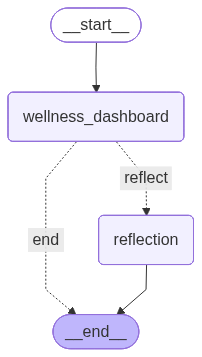

In [66]:

# Step 3: Build a wellness dashboard agent that:
#   - Retrieves user's wellness history
#   - Searches for relevant advice based on patterns
#   - Uses episodic memory for what worked before
#   - Generates a personalized summary

class WellnessState(TypedDict):
    messages: Annotated[list, add_messages]
    user_id: str
    feedback: str  # Style feedback for procedural update

def wellness_dashboard_agent(state: WellnessState, config: RunnableConfig, *, store: BaseStore):
    """
    Wellness dashboard agent that:
    - Retrieves user's wellness history
    - Searches for relevant advice based on patterns
    - Uses episodic memory for what worked before
    - Generates a personalized response
    """

    user_id = state["user_id"]
    user_message = state["messages"][-1].content

    # 1. PROCEDURAL: Get current instructions
    instructions_item = store.get(procedural_namespace, "wellness_assistant")
    instructions = instructions_item.value["instructions"] if instructions_item else "You are a helpful wellness assistant."

    # 2. User profile
    profile_item = store.get((user_id, "profile"), "user_info")
    profile_text = str(profile_item.value) if profile_item else "No profile stored."

    # 3. Wellness metrics history
    wellness_history = get_wellness_history(store, user_id, days=7)
    metrics_text = format_metrics(wellness_history)

    # 4. Past recommendations (for cross-thread context)
    past_recs = list(store.search(get_recommendations_namespace(user_id), query=user_message, limit=3))
    if past_recs:
        recs_text = "\n".join([f"- {r.value['date']}: {r.value['recommendation']}" for r in past_recs])
    else:
        recs_text = "None yet."
    
    # 5. Episodic memory - similar past interactions with positive feedback
    episodes = list(store.search(get_episodes_namespace(user_id), query=user_message, limit=2))
    if episodes:
        episodes_text = "\n".join([
            f"- Situation: {e.value['situation']}\n  What helped: {e.value['output']}\n  Result: {e.value['feedback']}"
            for e in episodes
        ])
    else:
        episodes_text = "No similar past interactions."

    # 6. Semantic knowledge - search for relevant advice
    knowledge = list(store.search(("wellness", "knowledge"), query=user_message, limit=2))
    if knowledge:
        knowledge_text = "\n".join([f"- {k.value.get('text', '')[:200]}..." for k in knowledge])
    else:
        knowledge_text = "No specific knowledge found."
    

    # Build system message with all context
    system_message = f"""{instructions}

=== USER PROFILE ===
{profile_text}

=== WELLNESS METRICS (Last 7 days) ===
{metrics_text}

**How to use:** Analyze patterns and trends. Look at notes for context on what affected each metric.

=== MY PAST RECOMMENDATIONS TO THIS USER FOR SIMILAR SITUATIONS ===
{recs_text}

**How to use:** Compare with metrics to see if recommendations worked. 
- If metrics improved after a recommendation (check notes), acknowledge it's working
- If metrics didn't improve, consider suggesting something different
- Example: "I suggested breathing technique on Jan 16, and I see your sleep improved from 5 to 8 by Jan 19"

=== PAST SUCCESSFUL INTERACTIONS ===
{episodes_text}

**How to use:** These are proven strategies that worked for this user before.
- Draw from these when giving new recommendations
- Reference them: "Last time you had low energy, the morning walk helped"
- Prioritize approaches that already worked over new suggestions

=== RELEVANT WELLNESS KNOWLEDGE ===
{knowledge_text}

**How to use:** Evidence-based wellness information to inform your recommendations.
- Combine with user's past successes to give personalized, evidence-backed advice
- Use to explain WHY a recommendation might help

=== RESPONSE GUIDELINES ===
- Reference specific dates and values ("I notice on Jan 16th your sleep dropped to 5/10...")
- Connect the dots between recommendations, notes, and metric changes
- If user mentions something helped, validate it with the data
- Keep responses concise but personalized"""

    # SHORT-TERM: Full conversation history is automatically managed by the checkpointer
    # Use summarization for long conversations from previous sessions of the same thread
    trimmed_messages = summarize_conversation(state["messages"], max_messages=6)
    
    messages = [SystemMessage(content=system_message)] + trimmed_messages
    response = llm.invoke(messages)

    # TODO: Extract and store recommendations from response
    # Options:
    # 1. Instruct LLM to output structured format with [RECOMMENDATIONS] section
    # 2. Use with_structured_output() for guaranteed schema
    # This enables the batch job to correlate recommendations with metric changes
    # For now, we use pre-populated recommendations from Step 2

    return {"messages": [response]}

def reflection_node(state: ProceduralState, config: RunnableConfig, *, store: BaseStore):
    """Reflect on feedback and update instructions if needed."""
    feedback = state.get("feedback", "")
    
    if not feedback:
        return {}  # No feedback, no update needed
    
    # Get current instructions
    current_instructions, version = get_instructions(store)
    
    # Ask the LLM to reflect and improve instructions
    reflection_prompt = f"""You are improving a wellness assistant's instructions based on user feedback.

Current Instructions:
{current_instructions}

User Feedback:
{feedback}

Based on this feedback, provide improved instructions. Keep the same general format but incorporate the feedback.
Only output the new instructions, nothing else."""
    
    response = llm.invoke([HumanMessage(content=reflection_prompt)])
    new_instructions = response.content
    
    # Update procedural memory with new instructions
    store.put(
        ("agent", "instructions"),
        "wellness_assistant",
        {"instructions": new_instructions, "version": version + 1}
    )
    
    print(f"\nInstructions updated to version {version + 1}")
    return {}


def should_reflect(state: ProceduralState) -> str:
    """Decide whether to reflect on feedback."""
    if state.get("feedback"):
        return "reflect"
    return "end"

# Build the graph
wellness_workflow = StateGraph(WellnessState)
wellness_workflow.add_node("wellness_dashboard", wellness_dashboard_agent)
wellness_workflow.add_node("reflection", reflection_node)

wellness_workflow.add_edge(START, "wellness_dashboard")
wellness_workflow.add_conditional_edges(
    "wellness_dashboard",
    should_reflect,
    {"reflect": "reflection", "end": END}
)
wellness_workflow.add_edge("reflection", END)


# Compile with checkpointer (short-term) and store (long-term)
wellness_graph = wellness_workflow.compile(
    checkpointer=MemorySaver(),
    store=wellness_store
)

# Visualize the graph
try:
    from IPython.display import display, Image
    display(Image(wellness_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(wellness_graph.get_graph().draw_ascii())


In [70]:

# Step 4: Test the dashboard
# Example: "Give me a summary of my wellness this week"
# Example: "I've been feeling tired lately. What might help?"

def chat(user_id: str, message: str, thread_id: str = "thread_id", feedback: str = ""):
    """Helper to chat with the wellness agent."""
    result = wellness_graph.invoke(
        {
            "messages": [HumanMessage(content=message)],
            "user_id": user_id,
            "feedback": feedback
        },
        {"configurable": {"thread_id": thread_id}}
    )
    return result["messages"][-1].content


print("=" * 60)
print("Test 1: Weekly Summary")
print("Testing: Metrics history + User profile")
print("=" * 60)
response = chat(USER_ID, "Give me a summary of my wellness this past week", thread_id="thread_morning_checkin")

print("User: Give me a summary of my wellness this past week")
print(f"\nAssistant:\n{response}")





Test 1: Weekly Summary
Testing: Metrics history + User profile
User: Give me a summary of my wellness this past week

Assistant:
Over the past week, your wellness metrics show some fluctuations, particularly in mood, energy, and sleep quality. Here’s a summary:

- **Mood:** Your mood varied, starting at 4/10 on January 17th when you were feeling off, and improving slightly to 6/10 by January 18th. You had a good day on January 15th with a mood rating of 7/10.
  
- **Energy:** Your energy levels were quite low, peaking at 6/10 on January 15th but dropping to 3/10 on January 17th when you felt exhausted and skipped exercise. 

- **Sleep:** Sleep quality was also inconsistent. You rated your sleep at 4/10 on January 17th, struggling to fall asleep, and had a better night on January 15th with a rating of 8/10. 

It seems that stress and possibly your busy schedule have impacted your energy and sleep. However, you did experience some improvement in mood and energy towards the end of the wee

In [71]:

print("\n" + "=" * 60)
print("Test 2: Follow-up question (same thread)")
print("Testing: Short-term memory")
print("=" * 60)
response = chat(USER_ID, "What happened on the 16th and 17th?", thread_id="thread_morning_checkin")

print("User: What happened on the 16th and 17th?")
print(f"\nAssistant:\n{response}")



Test 2: Follow-up question (same thread)
Testing: Short-term memory
User: What happened on the 16th and 17th?

Assistant:
On January 16th, you reported a mood of 5/10, indicating some stress, particularly related to a work deadline. Your energy level was at 4/10, which suggests you were feeling tired, likely due to the stress and possibly the previous night's sleep quality, which was rated at 5/10. You mentioned waking up at 3 AM with racing thoughts, which can definitely affect your overall energy and mood.

On January 17th, your mood dropped to 4/10, and your energy level fell further to 3/10, indicating you were feeling quite exhausted. You also skipped exercise that day, which might have contributed to the low energy. Your sleep quality was rated at 4/10, showing that you continued to struggle with falling asleep.

It seems that the stress from work and the disrupted sleep were significant factors affecting your wellness on those days. Would you like to discuss some strategies to 

In [72]:

print("\n" + "=" * 60)
print("Test 3: Ask for advice")
print("Testing: Episodic memory + Semantic knowledge + Short-term memory")
print("=" * 60)
response = chat(USER_ID, "I'm worried it might happen again. What should I do if I feel stressed?", thread_id="thread_morning_checkin")

print("User: I'm worried it might happen again. What should I do if I feel stressed?")
print(f"\nAssistant:\n{response}")



Test 3: Ask for advice
Testing: Episodic memory + Semantic knowledge + Short-term memory
User: I'm worried it might happen again. What should I do if I feel stressed?

Assistant:
It's completely understandable to feel worried about experiencing stress again, especially given how it impacted your mood and energy recently. Here are some strategies you can use when you start to feel stressed:

1. **Deep Breathing:** Try the 4-7-8 breathing technique. Inhale for 4 counts, hold for 7 counts, and exhale for 8 counts. This can help calm your nervous system and reduce feelings of anxiety.

2. **Progressive Muscle Relaxation:** This involves tensing and then relaxing different muscle groups in your body, starting from your toes and working your way up to your head. It can help release physical tension that often accompanies stress.

3. **Mindfulness or Grounding Techniques:** Take a moment to focus on your surroundings. Name five things you can see, four things you can touch, three things you 

In [73]:

print("\n" + "=" * 60)
print("Test 4: Procedural memory update")
print("=" * 60)

response = chat(
    USER_ID, 
    "Thanks! Can you give me a quick summary?",
    thread_id="thread_morning_checkin",
    feedback="Please use bullet points and keep responses brief"
)

print("User: Thanks! Can you give me a quick summary?")
print("Feedback: Please use bullet points and keep responses brief")
print(f"\nAssistant:\n{response}")

instructions_item = wellness_store.get(("agent", "instructions"), "wellness_assistant")
print(f"\n Procedural memory updated to v{instructions_item.value['version']} and updated instructions: {instructions_item.value['instructions']}")



Test 4: Procedural memory update

Instructions updated to version 2
User: Thanks! Can you give me a quick summary?
Feedback: Please use bullet points and keep responses brief

Assistant:
Absolutely! Here’s a quick summary of strategies to manage stress:

1. **Deep Breathing:** Use the 4-7-8 technique (inhale for 4 counts, hold for 7, exhale for 8) to calm your nervous system.

2. **Progressive Muscle Relaxation:** Tense and relax different muscle groups to release physical tension.

3. **Mindfulness/Grounding:** Focus on your surroundings by naming things you can see, touch, hear, smell, and taste.

4. **Short Walks:** Take a brief walk to clear your mind and boost your mood.

5. **Yoga/Stretching:** Incorporate gentle yoga or stretching to promote relaxation.

6. **Journaling:** Write down your thoughts and feelings to process stress.

These strategies can help you manage stress effectively. If you’d like to try any of them, let me know!

 Procedural memory updated to v2 and updated 

In [74]:
print("\n" + "=" * 60)
print("Test 5: Start a new thread and verfiy updated instructions")
print("=" * 60)
response = chat(USER_ID, "The breathing technique you suggested has been really helping!", thread_id="thread_followup")

print("User: The breathing technique you suggested has been really helping!")
print(f"\nAssistant:\n{response}")



Test 5: Start a new thread and verfiy updated instructions
User: The breathing technique you suggested has been really helping!

Assistant:
That's great to hear, Alex! I'm glad the 4-7-8 breathing technique is making a positive impact. 

- I see that your sleep improved from 5/10 to 8/10 after using it, which is fantastic!
- Consistent use of this technique can help further enhance your sleep quality and overall energy levels.

Would you like to explore any other strategies to support your energy and sleep, or continue focusing on the breathing exercises?


---
## Summary

In this session, we explored the **5 memory types** from the CoALA framework:

| Memory Type | LangGraph Component | Scope | Wellness Use Case |
|-------------|---------------------|-------|-------------------|
| **Short-term** | `MemorySaver` + `thread_id` | Within thread | Current consultation |
| **Long-term** | `InMemoryStore` + namespaces | Across threads | User profile, goals |
| **Semantic** | Store + embeddings + `search()` | Across threads | Knowledge retrieval |
| **Episodic** | Store + few-shot examples | Across threads | Past successful interactions |
| **Procedural** | Store + self-reflection | Across threads | Self-improving instructions |

### Key Takeaways:

1. **Memory transforms chatbots into assistants** - Persistence enables personalization
2. **Different memory types serve different purposes** - Choose based on your use case
3. **Context management is critical** - Trim and summarize to stay within limits
4. **Episodic memory enables learning** - Show, don't just tell
5. **Procedural memory enables adaptation** - Agents can improve themselves

### Production Considerations:

- Use `PostgresSaver` instead of `MemorySaver` for persistent checkpoints
- Use `PostgresStore` instead of `InMemoryStore` for persistent long-term memory
- Consider TTL (Time-to-Live) policies for automatic memory cleanup
- Implement proper access controls for user data

### Further Reading:

- [LangGraph Memory Documentation](https://langchain-ai.github.io/langgraph/concepts/memory/)
- [CoALA Paper](https://arxiv.org/abs/2309.02427) - Cognitive Architectures for Language Agents
- [LangGraph Platform](https://docs.langchain.com/langgraph-platform/) - Managed infrastructure for production